# Data Science Challenge
**Nombre:** Daniel Torres\
**Fecha de Entrega:** 17 de octubre de 2024

## Librerias

In [110]:
# Importación de librerías necesarias
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mip
from matplotlib.ticker import MultipleLocator
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Problema 1: Pregunta de optimización <a class="anchor" id="problema-1"></a>

## Descripción del Problema

Un hospital de Ciudad Gótica requiere generar horarios para los enfermeros de emergencia durante un periodo de 28 días, distribuidos en tres tipos de turnos:

- **AM:** 7:00 hrs a 15:00 hrs
- **PM:** 15:00 hrs a 23:00 hrs
- **NOCHE:** 23:00 hrs a 7:00 hrs

## Actividad 1

### Carga de Datos

Se carga el archivo de entrada `Input_Challenge.json` que contiene la demanda de personal por turno y día, así como el número total de enfermeros disponibles.


In [2]:
# Carga de los datos desde el archivo json
with open('Input_Challenge.json', 'r') as file:
    data = json.load(file)

demand = data["Demand"]
collabs = data["Collabs"]
shift_collab = data["Shift_Collab"]
shift_patterns = data["Shift_Patterns"]

### Formulación del Modelo de Optimización

#### Conjuntos

- $N$: Conjunto de enfermeros de emergencia
- $D$: Conjunto de dias
- $S$: Conjunto de tipos de turno
- $P$: Conjuntos de patrones de turno mensuales

#### Parametros
- $\text{U}_{n,p}$: 1 si el enfermero $n$ puede llevar a cabo el patron de turnos $p$, 0 de otra forma
- $\text{A}_{p,d,s}$: 1 si el patron $p$ asigna un turno de tipo $s$ el dia $d$, 0 de otra forma
- $E_{d,s}$: Cantidad necesaria de enfermeros para cubrir demanda del dia $d$ en el turno $s$

#### Variables de Decision

- $x_{n,d,s}$: 1 si el enfermero $n$ esta asignado el dia $d$ al turno $s$
- $y_{n,p}$: 1 si el enfermero $n$ esta asignado al patron de turnos $p$, 0 de otra forma
- $z_{d,s}$: Variable auxiliar de tipo entera usada para emular el comportamiento de funcion valor absoluto

#### Funciones

- $\text{Escasez}_{d,s}$: $E_{d,s}- \sum \limits_{n \in N} x_{n,d,s}$ 
- $\text{Exceso}_{d,s}$: $\sum \limits_{n \in N} x_{n,d,s} - E_{d,s}$ 

#### Restricciones duras
- Cada enfermero debe respetar el patron de turnos asignado

$
x_{n,d,s} \leq \sum \limits_{p \in P} (y_{n,p} \cdot A_{p,d,s}) ~~~~~~~~~~~~~ \forall n \in N, \forall d \in D, \forall s \in S
$

- Cada enfermero solo puede tomar un turno diario

$
\sum \limits_{s \in S} x_{n,d,s} \leq 1 ~~~~~~~~~~~~~ \forall n \in N, \forall d \in D
$

- Cada enfermero solo puede ser asignado a patrones de turno que sean admitidos por $U_{n,p}$

$
y_{n,p} \leq \text{U}_{n,p} ~~~~~~~~~~~~~ \forall n \in N, \forall p \in P
$

- Cada enfermero solo puede ser asignado a un patron de turnos

$
\sum \limits_{p \in P} y_{n,p} \leq 1 ~~~~~~~~~~~~~ \forall n \in N
$

<!-- - Todo turno en cada dia debe estar cubierto por al menos 1 enfermero

$
\sum \limits_{n \in N} x_{n,d,s} \geq 1 ~~~~~~~~~~~~~ \forall d \in D, \forall s \in S
$ -->

- Debido a que $Exceso = -Escasez$, para obtener el valor absoluto y utilizarlo como elemento a minimizar se generan las siguientes desigualdades

$z_{d,s} \geq E_{d,s} - \sum \limits_{n \in N} x_{n,d,s} ~~~~~~~~~~~~~ \forall d \in D, \forall s \in S$

$z_{d,s} \geq -(E_{d,s} - \sum \limits_{n \in N} x_{n,d,s}) ~~~~~~~~~~~~~ \forall d \in D, \forall s \in S$
#### Función Objetivo

Debido a que $z_{d,s}$ representa tanto escasez como exceso, la funcion objetivo queda como:

$
\text{Minimizar} \sum \limits_{d \in D} \sum \limits_{s \in S} z_{d,s}
$

### Creacion modelo MIP

In [3]:
N = np.arange(len(collabs.values()))
D = np.arange(28)
P = np.arange(len(shift_patterns.keys()))
S = np.arange(3)

U = np.zeros((N.shape[0], P.shape[0]), dtype = int)
for n in N:
    for u in shift_collab[str(n)]:
        U[n][u] = 1

A = np.zeros((P.shape[0], D.shape[0], S.shape[0]), dtype = int)
for p in P:
    A[p] = np.array(shift_patterns[str(p)])

E = np.zeros((D.shape[0], S.shape[0]), dtype = int)
for i,j in enumerate(demand):
    dia = i//3
    turno = i%3
    E[dia][turno] = j

In [4]:
m = mip.Model(sense=mip.MINIMIZE, solver_name=mip.CBC)

# Variable de Decision
x = [[[m.add_var(name='x', var_type=mip.BINARY) for s in range(S.shape[0])] for d in range(D.shape[0])] for n in range(N.shape[0])]
y = [[m.add_var(name='y', var_type=mip.BINARY) for p in range(P.shape[0])] for n in range(N.shape[0])]
z = [[m.add_var(name='Z', var_type=mip.INTEGER) for s in range(S.shape[0])] for d in range(D.shape[0])]
# Restricciones

# Cada enfermero debe respetar el patron de turnos asignado
for n in N:
    for d in D:
        for s in S:
            m += x[n][d][s] - mip.xsum((A[p][d][s] * y[n][p]) for p in P) == 0

# Cada enfermero solo puede tomar un turno diario
for n in N:
    for d in D:
         m += mip.xsum(x[n][d][s] for s in S) <= 1

# Cada enfermero solo puede ser asignado a patrones de turno que sean admitidos
for n in N:
    for p in P:
        m += y[n][p] <= U[n][p]

# Cada enfermero solo puede ser asignado a un set de turnos

for n in N:
    m+= mip.xsum(y[n][p] for p in P) <= 1

# Todo turno debe tener que estar cubierto por al menos 1 enfermero

# for d in D:
#     for s in S:
#         m+= mip.xsum(x[n][d][s] for n in N) >= 1

for d in D:
    for s in S:
        m+= z[d][s] >= E[d][s] - mip.xsum(x[n][d][s] for n in N)
        m+= z[d][s] >= -(E[d][s] - mip.xsum(x[n][d][s] for n in N))

min_shortage = True
    
#La Escasez siempre debe ser mayor a 0
if min_shortage:
    # m+= mip.xsum(E[d][s] - mip.xsum(x[n][d][s] for n in N) for d in D for s in S) >= 0
    m.objective = mip.xsum(z[d][s] for d in D for s in S)
else:
    m+= mip.xsum(mip.xsum(x[n][d][s] for n in N) - E[d][s] for d in D for s in S) >= 0
    m.objective = mip.xsum((mip.xsum(x[n][d][s] for n in N) - E[d][s]) for d in D for s in S)

In [5]:
m.optimize()
if m.status == mip.OptimizationStatus.OPTIMAL:
    print(f'costo de solucion optima {m.objective_value} encontrado')
elif m.status == mip.OptimizationStatus.FEASIBLE:
    print(f'costo de solucion {m.objective_value} encontrado, best possible: {m.objective_bound}')
else:
    print(f'soluciones factibles no encontradas, la cota inferior es: {m.objective_bound}')
if m.status == mip.OptimizationStatus.OPTIMAL or m.status == mip.OptimizationStatus.FEASIBLE:
    y_sol = {"result":[]}
    for i in range(16):
        for j in range(100):
            if y[i][j].x == 1.0:
                y_sol["result"].append([i,j])

print(y_sol)     

Welcome to the CBC MILP Solver 
Version: Trunk
Build Date: Oct 24 2021 

Starting solution of the Linear programming relaxation problem using Primal Simplex

Clp0024I Matrix will be packed to eliminate 102400 small elements
Coin0506I Presolve 1083 (-2577) rows, 677 (-2351) columns and 5232 (-36856) elements
Clp1000I sum of infeasibilities 2.35014e-05 - average 2.17003e-08, 7 fixed columns
Coin0506I Presolve 968 (-115) rows, 579 (-98) columns and 5001 (-231) elements
Clp0029I End of values pass after 579 iterations
Clp0014I Perturbing problem by 0.001% of 1.3894738 - largest nonzero change 2.9603574e-05 ( 0.0014801787%) - largest zero change 2.9597463e-05
Clp0000I Optimal - objective value 98.764706
Clp0000I Optimal - objective value 98.764706
Coin0511I After Postsolve, objective 98.764706, infeasibilities - dual 0 (0), primal 0 (0)
Clp0000I Optimal - objective value 98.764706
Clp0000I Optimal - objective value 98.764706
Clp0000I Optimal - objective value 98.764706
Coin0511I After Posts

### Resultados

El resultado optimo para el caso entregado es:

[[1, 29], [2, 44], [3, 16], [4, 63], [5, 83], [6, 97], [7, 91], [8, 14], [9, 52], [10, 43], [11, 50], [12, 0], [13, 8], [15, 4]]



## Actividad 2

1. **Reducir los patrones de un ámbito mensual a uno semanal**

Reducir el horizonte de planificación de mensual a semanal podría ofrecer una mayor flexibilidad en la programación de turnos. Esto permitiría planificar en periodos más cortos, lo que podría aumentar el espacio de búsqueda y permitir soluciones más ágiles que se ajusten mejor a las necesidades cambiantes de los enfermeros y del sistema. Esta modificación ayudaría a dar mayor holgura a la asignación de turnos y a adaptarse mejor a las variaciones en la disponibilidad y demanda.

2. **Aumentar los grados de libertad en los patrones de turnos**

Una mejora importante sería flexibilizar la noción de patrones mensuales de turnos, que en su forma actual puede resultar demasiado restrictiva. En lugar de depender únicamente de patrones predefinidos, se podría extraer información clave para adaptar mejor los turnos a las necesidades individuales de cada enfermero. Algunos elementos que podrían incorporarse son:

- Número mínimo de días libres consecutivos para cada enfermero.
- Número máximo de días consecutivos trabajados.
- Días en los que el enfermero no pueda trabajar debido a compromisos previos o restricciones personales.

Al incluir estas condiciones, el modelo tendría más grados de libertad para encontrar soluciones factibles, que no solo cumplan con las restricciones operativas sino que también tengan en cuenta las preferencias individuales. Esto podría mejorar tanto la eficiencia del sistema como la satisfacción laboral de los enfermeros, ampliando el espacio de búsqueda para encontrar mejores asignaciones.

3. **Incorporar las preferencias de los enfermeros**

Si bien las preferencias de los enfermeros pueden verse como restricciones adicionales, es posible tratarlas como restricciones "blandas" que, aunque no son estrictamente necesarias, pueden mejorar considerablemente el ambiente laboral. Algunas preferencias que podrían tenerse en cuenta incluyen:

- Días preferidos por cada enfermero para trabajar.
- Turnos preferidos (de día o de noche, por ejemplo).
- Días libres preferidos o deseados.

Considerar estas preferencias no solo mejora el modelo desde el punto de vista del bienestar de los empleados, sino que también puede llevar a un aumento en la retención de personal y la satisfacción general, lo que a largo plazo puede traducirse en un servicio más eficiente y motivado.

4. **Uso de demandas dinámicas**

Aunque el problema actual se aborda de forma estática, existe la posibilidad de que la demanda de personal siga un comportamiento cíclico a lo largo de periodos específicos, como semanas, meses o años. Para abordar esto, se podría considerar el uso de modelos predictivos, como deep neural networks, junto a datos historicos, para anticipar la demanda futura en función de patrones históricos.

Al hacer la demanda más dinámica y ajustada a predicciones futuras, se podrían generar planes de turnos más ajustados a las necesidades del sistema de salud, optimizando la asignación de enfermeros y evitando escasez o exceso de personal en ciertos periodos. Esto también ayudaría a mejorar la capacidad de respuesta del sistema ante variaciones en la carga de trabajo.

## Actividad 3

In [7]:

# Inicializa arreglos de dias, demanda y asignacion
plot_days = np.arange(28, dtype=int)
plot_demand = np.zeros((28, 3), dtype=int)  # 3 columns for AM, PM, Noche shifts
plot_asignacion = np.zeros((28, 3), dtype=int)

# Reemplazo valores de demanda directamente con slicing
plot_demand[:, :3] = E[:, :3]

# Actualizo las asignaciones retornadas por el modelo
for i in y_sol["result"]:
    shift_pattern = shift_patterns[str(i[1])]
    shift_array = np.array(shift_pattern)

    # suma de asignaciones por turno
    plot_asignacion[:, 0] += shift_array[:, 0]  # AM shift
    plot_asignacion[:, 1] += shift_array[:, 1]  # PM shift
    plot_asignacion[:, 2] += shift_array[:, 2]  # Noche shift

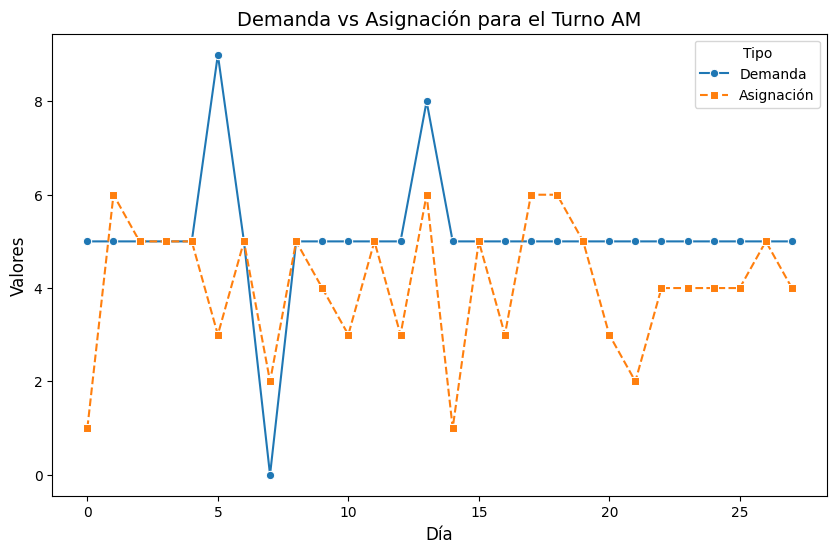

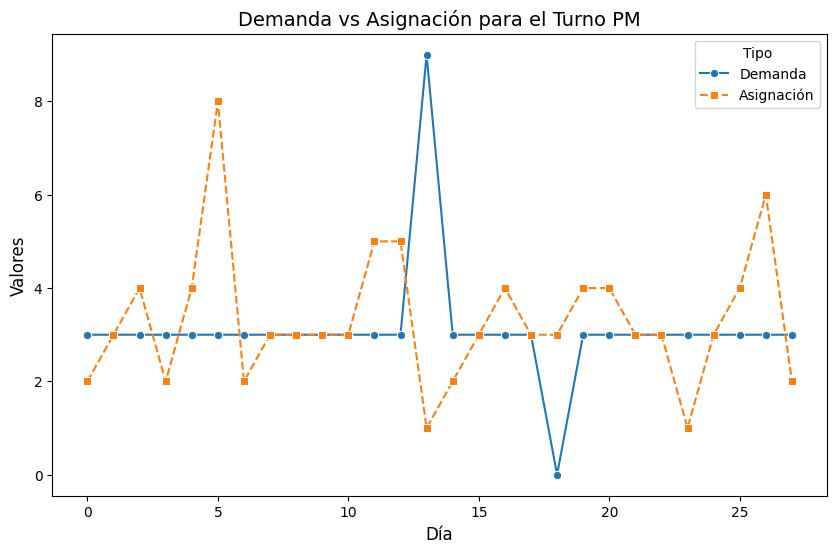

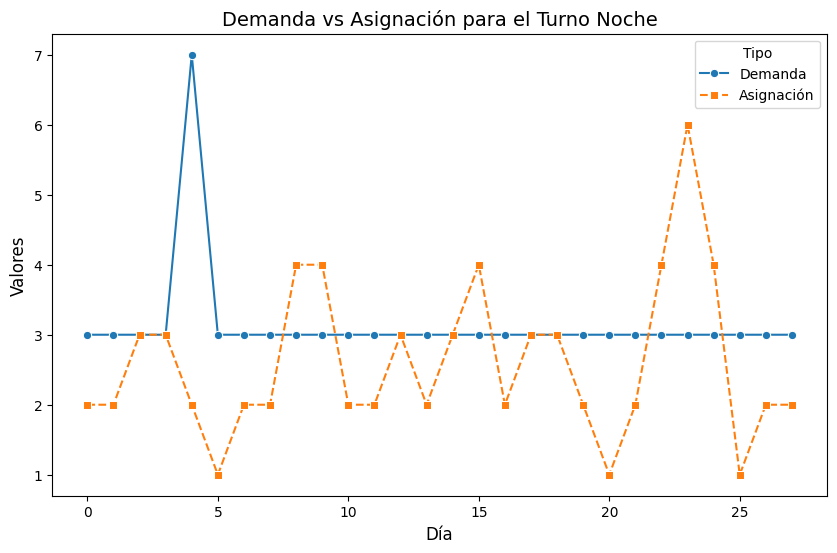

In [8]:
demand_shift_am = plot_demand[:, 0]
demand_shift_pm = plot_demand[:, 1]
demand_shift_noche = plot_demand[:, 2]

asignacion_turno_am = plot_asignacion[:, 0]
asignacion_turno_pm = plot_asignacion[:, 1]
asignacion_turno_noche = plot_asignacion[:, 2]

# Crear un DataFrame para cada turno
data_am = pd.DataFrame({
    'Día': plot_days,
    'Demanda': demand_shift_am,
    'Asignación': asignacion_turno_am,
})

data_pm = pd.DataFrame({
    'Día': plot_days,
    'Demanda': demand_shift_pm,
    'Asignación': asignacion_turno_pm,
})

data_noche = pd.DataFrame({
    'Día': plot_days,
    'Demanda': demand_shift_noche,
    'Asignación': asignacion_turno_noche,
})

# Gráfico para el turno AM
plt.figure(figsize=(10, 6))
sns.lineplot(x='Día', y='Demanda', data=data_am, marker="o", label='Demanda', linestyle='-')
sns.lineplot(x='Día', y='Asignación', data=data_am, marker="s", label='Asignación', linestyle='--')
plt.title('Demanda vs Asignación para el Turno AM', fontsize=14)
plt.xlabel('Día', fontsize=12)
plt.ylabel('Valores', fontsize=12)
plt.legend(title='Tipo')
plt.show()

# Gráfico para el turno PM
plt.figure(figsize=(10, 6))
sns.lineplot(x='Día', y='Demanda', data=data_pm, marker="o", label='Demanda', linestyle='-')
sns.lineplot(x='Día', y='Asignación', data=data_pm, marker="s", label='Asignación', linestyle='--')
plt.title('Demanda vs Asignación para el Turno PM', fontsize=14)
plt.xlabel('Día', fontsize=12)
plt.ylabel('Valores', fontsize=12)
plt.legend(title='Tipo')
plt.show()

# Gráfico para el turno Noche
plt.figure(figsize=(10, 6))
sns.lineplot(x='Día', y='Demanda', data=data_noche, marker="o", label='Demanda', linestyle='-')
sns.lineplot(x='Día', y='Asignación', data=data_noche, marker="s", label='Asignación', linestyle='--')
plt.title('Demanda vs Asignación para el Turno Noche', fontsize=14)
plt.xlabel('Día', fontsize=12)
plt.ylabel('Valores', fontsize=12)
plt.legend(title='Tipo')
plt.show()


Se observa que todos los turnos presentan una demanda promedio, junto con máximos y mínimos locales que surgen esporádicamente.

Un aspecto destacado es que el uso de patrones de turnos complica la cobertura perfecta de la demanda, lo que provoca una variabilidad significativa en la asignación de enfermeros. Esto es especialmente evidente en los turnos nocturnos, donde la mayoría de los días hay una escasez de enfermeros, y en dos días se generan excesos de hasta seis enfermeros, seguidos por otros dos días con un exceso de cuatro enfermeros. Además, los otros dos gráficos (AM y PM) refuerzan la idea de que los patrones de turnos mensuales impiden una correcta cobertura, ya que se observa lo errático que se comportan las asignaciones tanto en excesos como en escasez de personal. Esta irregularidad en la disponibilidad de personal resalta la necesidad de reconsiderar los patrones de turno para lograr una asignación más equilibrada o directamente cambiarlos por algun metodo que permita tener mas grados de libertad a la hora de asignar turnos.

# Problema 2: Pregunta de Machine Learning

Un supermercado desea saber cuál es la cantidad de ventas (transacciones) que tendrá
en el mes de octubre. Para esto, contrata a SCM con el ﬁn de obtener esta información del
futuro.

## Actividad 1

### Carga y limpieza de datos

In [114]:
df = pd.read_excel('TRX_SUPERMERCADO.xlsx', header=0)

df.head()

,Fecha,Driver,00:00,00:15,00:30,00:45,01:00,01:15,01:30,01:45,...,21:30,21:45,22:00,22:15,22:30,22:45,23:00,23:15,23:30,23:45
0,2024-07-01,CANTIDAD_TRX,0,0,0,0,0,0,0,0,...,24.0,26,13,0,0,0,0,0,0,0
1,2024-07-01,TRX_EFECTIVO,0,0,0,0,0,0,0,0,...,0.0,0,0,0,0,0,0,0,0,0
2,2024-07-01,TRX_TARJETA,0,0,0,0,0,0,0,0,...,0.0,0,0,0,0,0,0,0,0,0
3,2024-07-02,CANTIDAD_TRX,0,0,0,0,0,0,0,0,...,23.0,18,16,2,0,0,0,0,0,0
4,2024-07-02,TRX_EFECTIVO,0,0,0,0,0,0,0,0,...,6.0,4,6,0,0,0,0,0,0,0


**Observando df.head() inmediatamente salta a la vista el hecho de campos mal calculados, tal como los 3 elementos de 2024-07-01 a las 21:30.**

In [115]:
df.select_dtypes(exclude=['int64', 'float64']).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268 entries, 0 to 267
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Fecha   268 non-null    datetime64[ns]
 1   Driver  268 non-null    object        
 2   11:45   267 non-null    object        
dtypes: datetime64[ns](1), object(2)
memory usage: 6.4+ KB


**El hecho que la columna 11:45 sea de tipo string, indica que debe existir datos no numericos en alguna variable**

In [116]:
# se reemplaza el error

try:
    pd.to_numeric(df['11:45'], errors='raise')
except Exception as e:
    print(e)

Unable to parse string "dos" at position 80


In [117]:
# TODO: Estandarizar correccion de datos
df.at[80,"11:45"] = 2
# Se reemplaza manualmente el dato no numerico
df['11:45'] = pd.to_numeric(df['11:45'], errors='raise')
df.select_dtypes(exclude=['int64', 'float64']).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268 entries, 0 to 267
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Fecha   268 non-null    datetime64[ns]
 1   Driver  268 non-null    object        
dtypes: datetime64[ns](1), object(1)
memory usage: 4.3+ KB


In [118]:
# Identificar y tratar datos nulos o mal calculados

null_rows = df[df.isnull().any(axis=1)]
null_rows

,Fecha,Driver,00:00,00:15,00:30,00:45,01:00,01:15,01:30,01:45,...,21:30,21:45,22:00,22:15,22:30,22:45,23:00,23:15,23:30,23:45
47,2024-07-17,TRX_EFECTIVO,0,0,0,0,0,0,0,0,...,9.0,9,4,0,0,0,0,0,0,0
123,2024-08-12,TRX_TARJETA,0,0,0,0,0,0,0,0,...,25.0,14,9,2,0,0,0,0,0,0
130,2024-08-15,CANTIDAD_TRX,0,0,0,0,0,0,0,0,...,NaN,29,18,1,0,0,0,0,0,0
159,2024-08-24,TRX_TARJETA,0,0,0,0,0,0,0,0,...,NaN,21,9,0,0,0,0,0,0,0
259,2024-09-27,CANTIDAD_TRX,0,0,0,0,0,0,0,0,...,19.0,21,12,0,0,0,0,0,0,0


In [120]:


# Todos los valores nulos estan acompa;ados de los demas valores en la fecha, por lo que pueden ser calculados

null_rows = df[df.isnull().any(axis=1)]

for i, row in null_rows.iterrows():
    rows_fecha = df[df["Fecha"] == row["Fecha"]]
    null_col = row[row.isnull()].index
    for nc in null_col:
        if row["Driver"] == "CANTIDAD_TRX":
            valor = rows_fecha[rows_fecha["Driver"] != "CANTIDAD_TRX"][nc].sum()
            df.at[i, nc] = valor
            
        elif row["Driver"] == "TRX_EFECTIVO":
            # Calculate value as CANTIDAD_TRX - TRX_TARJETA
            cantidad_trx = rows_fecha[rows_fecha["Driver"] == "CANTIDAD_TRX"][nc].values[0]
            trx_tarjeta = rows_fecha[rows_fecha["Driver"] == "TRX_TARJETA"][nc].values[0]
            valor = cantidad_trx - trx_tarjeta
            df.at[i, nc] = valor
            
        elif row["Driver"] == "TRX_TARJETA":
            # Calculate value as CANTIDAD_TRX - TRX_EFECTIVO
            cantidad_trx = rows_fecha[rows_fecha["Driver"] == "CANTIDAD_TRX"][nc].values[0]
            trx_efectivo = rows_fecha[rows_fecha["Driver"] == "TRX_EFECTIVO"][nc].values[0]
            valor = cantidad_trx - trx_efectivo
            df.at[i, nc] = valor



In [121]:
null_rows = df[df.isnull().any(axis=1)]
null_rows

,Fecha,Driver,00:00,00:15,00:30,00:45,01:00,01:15,01:30,01:45,...,21:30,21:45,22:00,22:15,22:30,22:45,23:00,23:15,23:30,23:45


In [12]:
unique_fechas = df.Fecha.unique()
for uf in unique_fechas:
    if str(uf) == '2024-07-09 00:00:00':
        continue
    rows_fecha = df[df["Fecha"] == uf]
    h_cols = df.columns[2:]
    for hc in h_cols:
        if rows_fecha[rows_fecha["Driver"] == "TRX_TARJETA"][hc].values.size == 0:
            print(uf, hc, rows_fecha[rows_fecha["Driver"] == "TRX_TARJETA"][hc])
        cantidad_trx = rows_fecha[rows_fecha["Driver"] == "CANTIDAD_TRX"][hc].values[0]
        trx_tarjeta = rows_fecha[rows_fecha["Driver"] == "TRX_TARJETA"][hc].values[0]
        trx_efectivo = rows_fecha[rows_fecha["Driver"] == "TRX_EFECTIVO"][hc].values[0]
        
        if trx_tarjeta + trx_efectivo > cantidad_trx:
            cantidad_trx = trx_tarjeta + trx_efectivo
        elif trx_tarjeta + trx_efectivo < cantidad_trx:
            if cantidad_trx%2 == 0:
                trx_tarjeta = cantidad_trx/2
                trx_efectivo = cantidad_trx/2
            else:
                trx_tarjeta = cantidad_trx//2
                trx_efectivo = cantidad_trx//2 + 1
        
        # Update the dataset
        df.loc[(df["Driver"] == "CANTIDAD_TRX") & (df["Fecha"] == uf), hc] = cantidad_trx
        df.loc[(df["Driver"] == "TRX_TARJETA") & (df["Fecha"] == uf), hc] = trx_tarjeta
        df.loc[(df["Driver"] == "TRX_EFECTIVO") & (df["Fecha"] == uf), hc] = trx_efectivo

df.head()

,Fecha,Driver,00:00,00:15,00:30,00:45,01:00,01:15,01:30,01:45,...,21:30,21:45,22:00,22:15,22:30,22:45,23:00,23:15,23:30,23:45
0,2024-07-01,CANTIDAD_TRX,0,0,0,0,0,0,0,0,...,24.0,26,13,0,0,0,0,0,0,0
1,2024-07-01,TRX_EFECTIVO,0,0,0,0,0,0,0,0,...,12.0,13,7,0,0,0,0,0,0,0
2,2024-07-01,TRX_TARJETA,0,0,0,0,0,0,0,0,...,12.0,13,6,0,0,0,0,0,0,0
3,2024-07-02,CANTIDAD_TRX,0,0,0,0,0,0,0,0,...,23.0,18,16,2,0,0,0,0,0,0
4,2024-07-02,TRX_EFECTIVO,0,0,0,0,0,0,0,0,...,6.0,4,6,0,0,0,0,0,0,0


En relación a la discrepancia de valores entre **TRX_TARJETA + TRX_EFECTIVO** y **CANTIDAD_TRX**, resulta extraño que un sistema de información automatizado en un supermercado registre datos erróneos de esta forma. Una posible explicación es que el registro de transacciones esté a cargo de una persona, lo que podría llevar a errores humanos. Esto me lleva a la conclusión de que, en algunas ocasiones, el operador olvida registrar parte de la información, lo que genera estas inconsistencias. En este análisis, siempre consideré el valor mayor como el real, ya que es más probable que el operador omita el registro de una transacción a que ingrese de forma incorrecta múltiples veces el mismo valor. Por lo tanto, si TRX_TARJETA + TRX_EFECTIVO es mayor que CANTIDAD_TRX, se corregirá CANTIDAD_TRX para igualar la suma de ambos. En el caso contrario, si CANTIDAD_TRX es mayor, se dividirá en partes iguales entre TRX_TARJETA y TRX_EFECTIVO si es par, y si es impar, uno de ellos tendrá un registro adicional para ajustar la diferencia, ya que los valores deben ser enteros.

### Exploracion de los datos

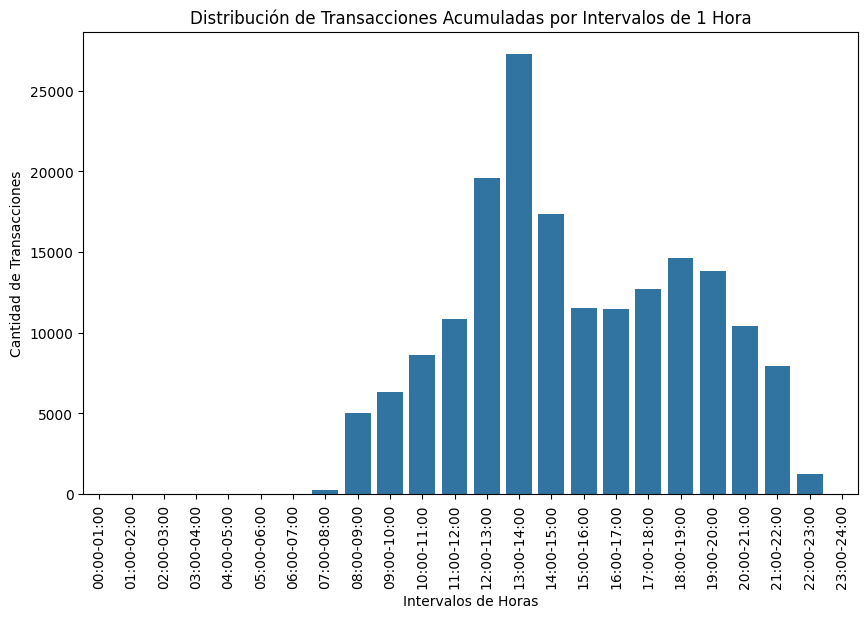

In [13]:
# Identificar las columnas horarias
columnas_horas = df.columns[2:]

# Crear grupos de 4 columnas (correspondientes a intervalos de una hora)
grupo_horas = [columnas_horas[i:i+4] for i in range(0, len(columnas_horas), 4)]


transacciones_por_hora_grupo = pd.DataFrame()

for i, grupo in enumerate(grupo_horas):
    transacciones_por_hora_grupo[f'{i:02d}:00-{i+1:02d}:00'] = df[df["Driver"] == "CANTIDAD_TRX"][grupo].sum(axis=1)


transacciones_acumuladas = transacciones_por_hora_grupo.sum()


plt.figure(figsize=(10,6))
sns.barplot(x=transacciones_acumuladas.index, y=transacciones_acumuladas.values)
plt.xticks(rotation=90)
plt.title('Distribución de Transacciones Acumuladas por Intervalos de 1 Hora')
plt.ylabel('Cantidad de Transacciones')
plt.xlabel('Intervalos de Horas')
plt.show()


El gráfico que muestra la distribución acumulada de transacciones por intervalos de una hora revela un patrón distintivo en el comportamiento de las compras a lo largo del día. Se observa un aumento gradual en el número de transacciones, alcanzando un pico notable alrededor de las 13:00. Este incremento puede atribuirse a los horarios de colación, donde las personas tienden a realizar más compras. Posteriormente, se presenta un segundo pico a las 19:00, lo que sugiere un aumento en la actividad de compras relacionado con la salida del trabajo y el regreso a casa. Este análisis resalta la influencia de los horarios laborales en los patrones de consumo.

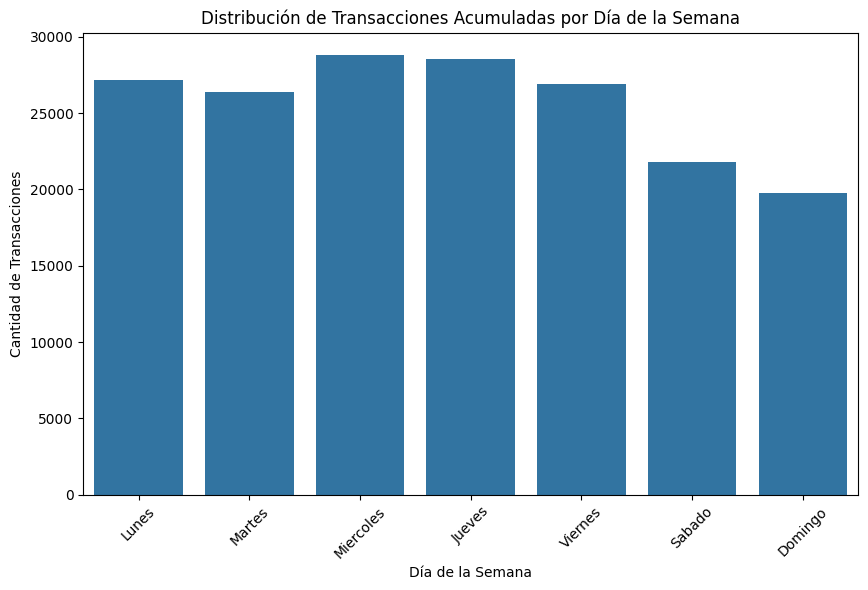

In [14]:
# Crear una nueva columna para el día de la semana (0=lunes, 6=domingo)
df['Dia_Semana'] = df['Fecha'].dt.dayofweek  # Esto devuelve un entero del 0 al 6

# Sumar las transacciones por día de la semana
transacciones_por_dia = df[df["Driver"] == "CANTIDAD_TRX"].groupby('Dia_Semana')[columnas_horas].sum().sum(axis=1)

# Reordenar los días de la semana
dias_orden = ['Lunes', 'Martes', 'Miercoles', 'Jueves', 'Viernes', 'Sabado', 'Domingo']
transacciones_por_dia = transacciones_por_dia.reindex(range(7))  # Asegurarse de que todos los días estén presentes
transacciones_por_dia.index = dias_orden  # Cambiar el índice a los nombres de los días

# Graficar la distribución de transacciones por día de la semana
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=transacciones_por_dia.index, y=transacciones_por_dia.values)

# Añadir los valores encima de cada barra
# for i, valor in enumerate(transacciones_por_dia.values):
#     ax.text(i, valor + 0.5, f'{valor:.0f}', ha='center', va='bottom')

plt.xticks(rotation=45)
plt.title('Distribución de Transacciones Acumuladas por Día de la Semana')
plt.ylabel('Cantidad de Transacciones')
plt.xlabel('Día de la Semana')
plt.show()

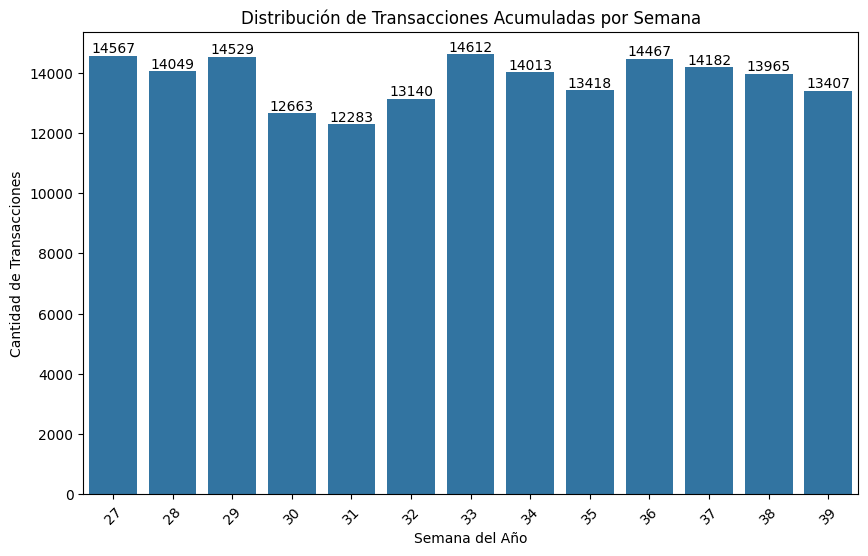

In [15]:
# Crear una nueva columna para la semana del año
df['Semana_Año'] = df['Fecha'].dt.isocalendar().week  # Esto devuelve el número de la semana

# Sumar las transacciones por semana
transacciones_por_semana = df[df["Driver"] == "CANTIDAD_TRX"].groupby('Semana_Año')[columnas_horas].sum().sum(axis=1)

# Graficar la distribución de transacciones por semana
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=transacciones_por_semana.index, y=transacciones_por_semana.values)

# Añadir los valores encima de cada barra
for i, valor in enumerate(transacciones_por_semana.values):
    ax.text(i, valor + 0.5, f'{valor:.0f}', ha='center', va='bottom')

plt.xticks(rotation=45)
plt.title('Distribución de Transacciones Acumuladas por Semana')
plt.ylabel('Cantidad de Transacciones')
plt.xlabel('Semana del Año')
plt.show()


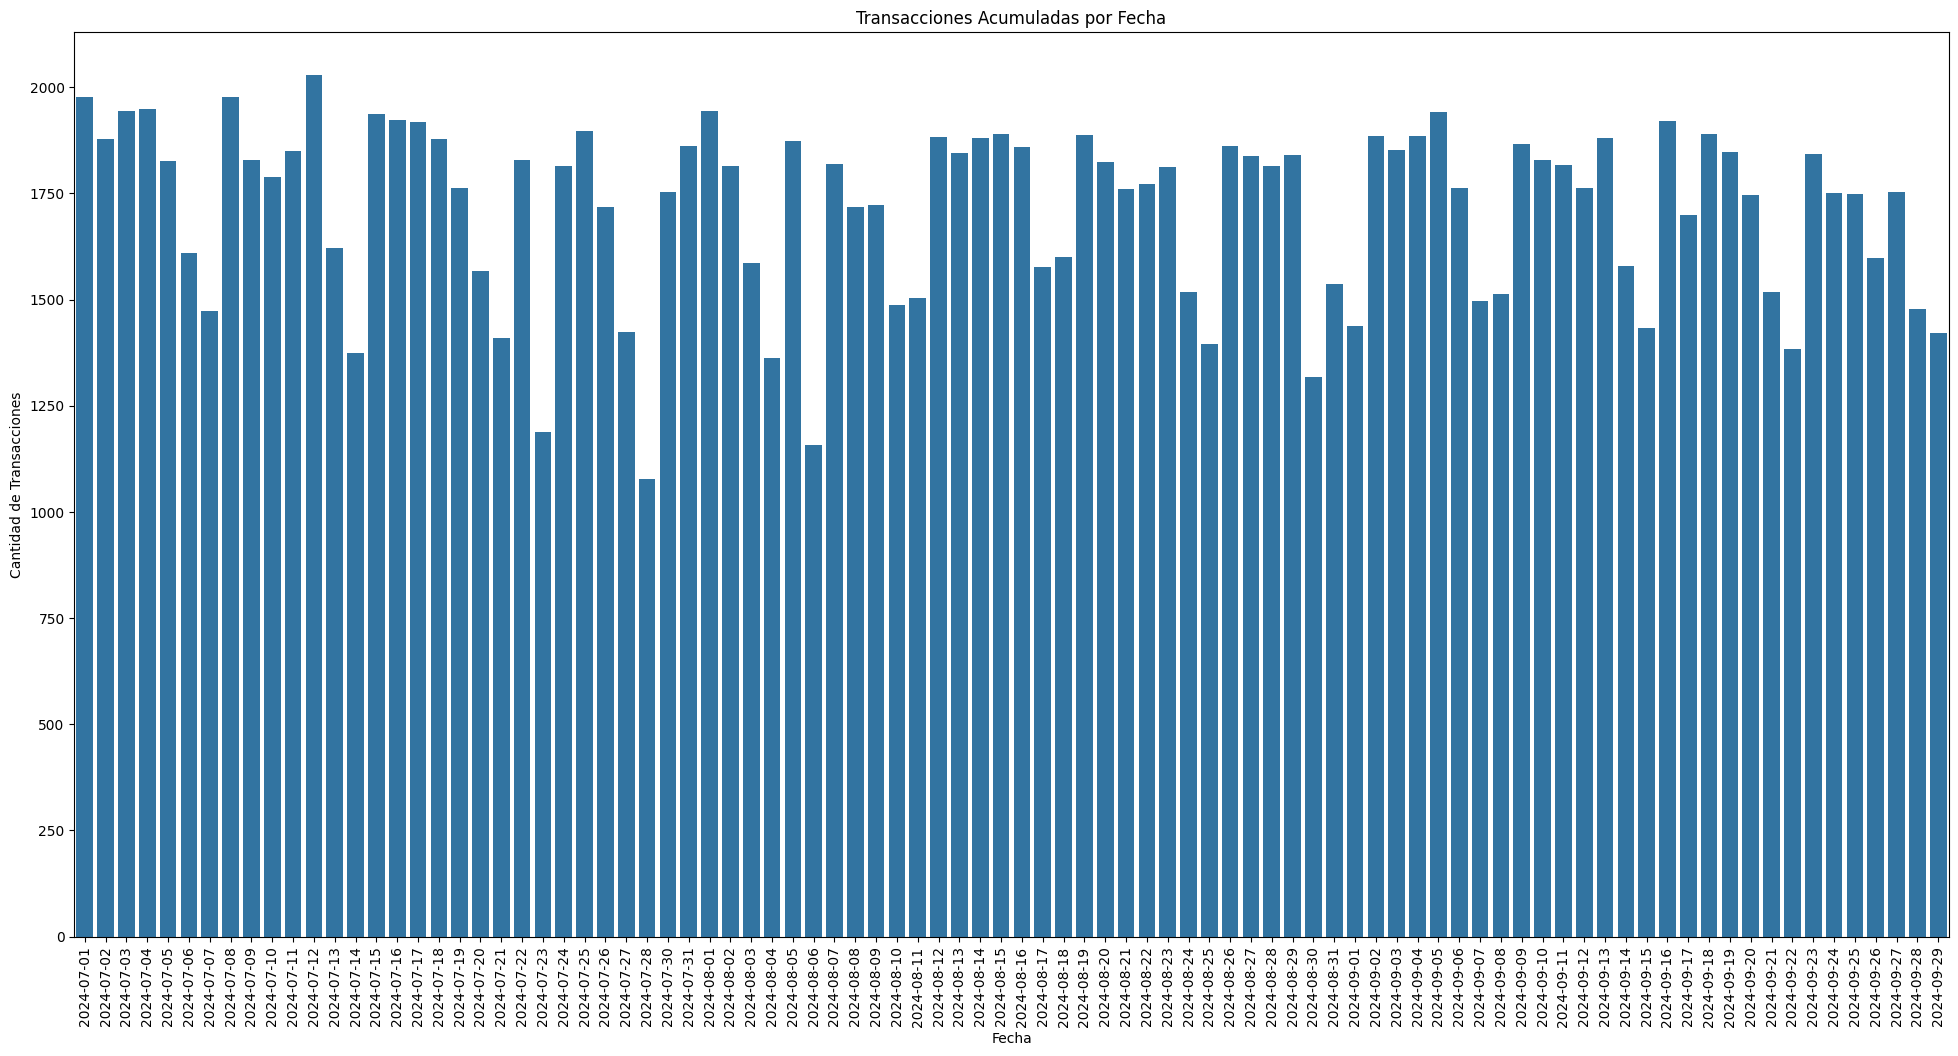

In [128]:
# # Crear una nueva columna para el total de transacciones
# total_transacciones = df[df["Driver"] == "CANTIDAD_TRX"][columnas_horas].sum(axis=1)

# print(total_transacciones.size)


# # Graficar transacciones acumuladas por fecha
# plt.figure(figsize=(20, 10))
# sns.barplot(x= df[df["Driver"] == "CANTIDAD_TRX"]["Fecha"], y= total_transacciones)
# plt.title('Transacciones Acumuladas por Fecha')
# plt.ylabel('Cantidad de Transacciones')
# plt.xlabel('Fecha')
# plt.xticks(rotation=90)
# plt.tight_layout()
# plt.show()

total_transacciones = df[df["Driver"] == "CANTIDAD_TRX"][columnas_horas].sum(axis=1)

# Graficar transacciones acumuladas por fecha
plt.figure(figsize=(20, 10))
ax = sns.barplot(x=df[df["Driver"] == "CANTIDAD_TRX"]["Fecha"], y=total_transacciones)
# ax.xaxis.set_major_locator(MultipleLocator(8))
plt.title('Transacciones Acumuladas por Fecha')
plt.ylabel('Cantidad de Transacciones')
plt.xlabel('Fecha')
# plt.ylim(1100,2600)
# ax.set_xlim(df['Fecha'].min(), df['Fecha'].max())
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

El análisis de los gráficos muestra patrones interesantes respecto a las transacciones a lo largo del tiempo. En el primer gráfico, que representa las transacciones diarias distribuidas por día de la semana, se aprecia un leve aumento hacia la mitad de la semana, con un ligero descenso hacia los fines de semana. Sin embargo, esta tendencia no es completamente clara, lo que dificulta establecer una conclusión precisa sobre la distribución de las transacciones.

Por otro lado, el tercer gráfico, que abarca las transacciones desde el 01/07/2024 hasta el 29/09/2024, replica de manera más evidente el comportamiento observado en el primero. Aquí, el aumento de transacciones a mitad de cada semana es mucho más claro, pero además revela una tendencia general donde las transacciones disminuyen gradualmente cada semana, alcanzando su punto más bajo los domingos. Este patrón se repite consistentemente hasta finales de cada mes, siendo especialmente evidente en los meses de julio y la primera mitad de agosto. El gráfico agrupado por semanas refuerza la idea de un comportamiento estacional hacia septiembre, donde las Fiestas Patrias parecen influir en la estabilización del patrón de descenso semanal.

A partir de mediados de agosto, el comportamiento de las transacciones comienza a estancarse, y el patrón de disminución semanal deja de ser tan pronunciado. Aunque se conserva la tendencia semanal observada en el primer gráfico, el comportamiento general de las transacciones por semana parece estabilizarse. Considerando que en Chile este periodo coincide con la preparación para las Fiestas Patrias en septiembre, es posible que este cambio en el patrón se deba a un factor estacional, donde el aumento de la actividad económica por estas festividades genera una estabilización en el descenso de transacciones durante el mes.

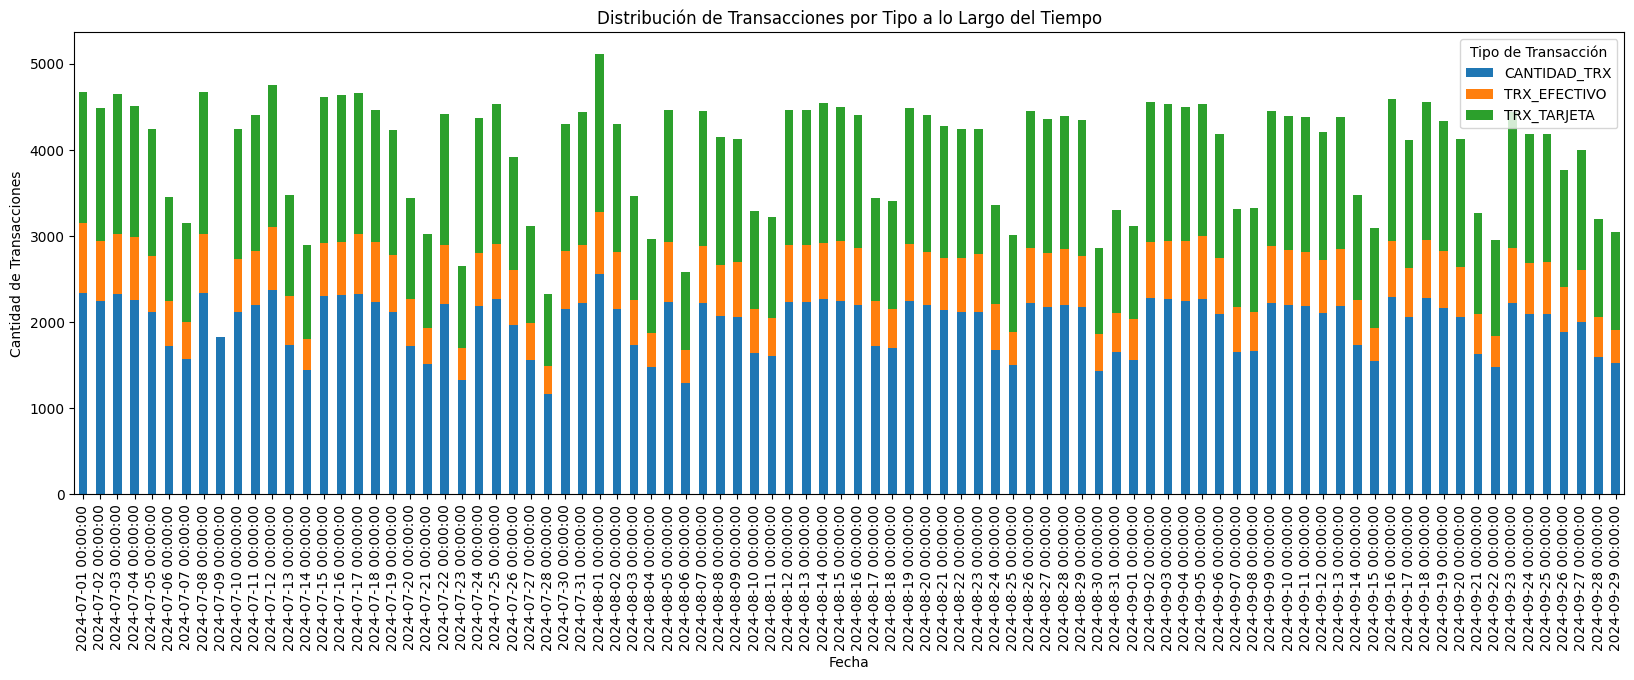

In [17]:
df_grouped = df.groupby(['Fecha', 'Driver'])[columnas_horas].sum().sum(axis=1).unstack()

df_grouped.plot(kind='bar', stacked=True, figsize=(20, 6))
plt.title('Distribución de Transacciones por Tipo a lo Largo del Tiempo')
plt.ylabel('Cantidad de Transacciones')
plt.xlabel('Fecha')
plt.xticks(rotation=90)
plt.legend(title='Tipo de Transacción')
plt.show()


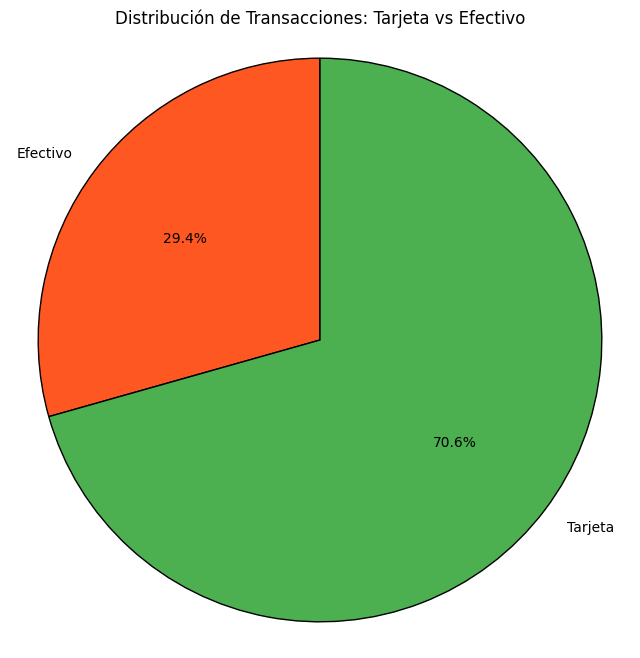

In [18]:
# Agrupar las transacciones por tipo (Tarjeta vs Efectivo) y sumar
transacciones_totales = df[df["Driver"].isin(["TRX_TARJETA", "TRX_EFECTIVO"])]
transacciones_por_tipo = transacciones_totales.groupby('Driver')[columnas_horas].sum().sum(axis=1)

# Etiquetas para el gráfico
etiquetas = ['Efectivo','Tarjeta']

# Colores para diferenciar
colores = ['#FF5722','#4CAF50']

# Crear el gráfico circular
plt.figure(figsize=(8, 8))
plt.pie(transacciones_por_tipo, labels=etiquetas, colors=colores, autopct='%1.1f%%', startangle=90, wedgeprops={'linewidth': 1.0, 'edgecolor': 'black'})
plt.title('Distribución de Transacciones: Tarjeta vs Efectivo')
plt.axis('equal')  # Para que el gráfico sea circular
plt.show()

Tanto en el gráfico por fecha como en el gráfico de las transacciones acumuladas durante todo el período, se observa una clara preferencia de los clientes por el uso de tarjetas en lugar de efectivo. Aproximadamente el 70% de todas las transacciones se realizan con tarjeta, lo que sugiere que este método de pago es significativamente más popular.

Las razones de esta preferencia pueden ser diversas y requerirían un estudio más profundo para obtener conclusiones definitivas. Sin embargo, factores como la seguridad que ofrece el pago con tarjeta, la facilidad de uso y la capacidad de manejar grandes cantidades de dinero sin necesidad de transportar efectivo físico probablemente juegan un papel importante en esta tendencia.

In [19]:
df.drop(columns=['Dia_Semana'], inplace=True)
df.drop(columns=['Semana_Año'], inplace=True)

df_original = df.copy()

In [86]:
df = df_original.copy()

mapping = {
    'CANTIDAD_TRX': 0,
    'TRX_TARJETA': 1,
    'TRX_EFECTIVO': 2
}

# Reemplazar los valores en la columna 'Driver' usando el mapeo
df['Driver'] = df['Driver'].replace(mapping)

tiempos = [f'{str(i).zfill(2)}:{str(j).zfill(2)}' for i in range(24) for j in range(0, 60, 15)]

# Crear un nuevo DataFrame para almacenar las filas reestructuradas
data = []

# Iterar sobre cada fila del DataFrame original
for index, row in df.iterrows():
    fecha = row['Fecha']
    driver = row['Driver']
    
    # Crear una fila para cada columna de tiempo
    for tiempo in tiempos:
        # Obtener la cantidad de transacciones para esa hora
        transacciones = row[tiempo]
        
        # Agregar la información al nuevo DataFrame
        data.append([fecha, driver, tiempo, transacciones])

# Crear un nuevo DataFrame a partir de la lista de datos
df_largo = pd.DataFrame(data, columns=['Fecha', 'Driver', 'Hora_15min', 'Transacciones'])

# Separar la columna 'Hora_15min' en horas y minutos
df_largo['Hora'] = df_largo['Hora_15min'].apply(lambda x: int(x.split(':')[0]))
df_largo['Minuto'] = df_largo['Hora_15min'].apply(lambda x: int(x.split(':')[1]))

# Crear columnas para día, mes y año
df_largo['Dia'] = df_largo['Fecha'].dt.day
df_largo['Mes'] = df_largo['Fecha'].dt.month
df_largo['Año'] = df_largo['Fecha'].dt.year


# Imprimir el DataFrame resultante
print(df_largo.head())

       Fecha  Driver Hora_15min  Transacciones  Hora  Minuto  Dia  Mes   Año
0 2024-07-01       0      00:00            0.0     0       0    1    7  2024
1 2024-07-01       0      00:15            0.0     0      15    1    7  2024
2 2024-07-01       0      00:30            0.0     0      30    1    7  2024
3 2024-07-01       0      00:45            0.0     0      45    1    7  2024
4 2024-07-01       0      01:00            0.0     1       0    1    7  2024


C:\Users\Daniel Torres\AppData\Local\Temp\ipykernel_47196\2497563573.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Driver'] = df['Driver'].replace(mapping)


In [94]:


# Debido a que las predicciones deben ser diarias, no tiene sentido mantener el data set en un formato desglosado

ac = []
for f in df_largo["Fecha"].unique():
    for h in df_largo["Hora_15min"].unique():
        suma_transacciones = df_largo[(df_largo['Fecha'] == f) & (df_largo['Hora_15min'] == h) & (df_largo['Driver'] == 0)]['Transacciones'].sum()
        ac.append([f, suma_transacciones, f.day, f.month, int(h.split(':')[0]), int(h.split(':')[1])])
print(ac[0])
df_desglosado = pd.DataFrame(ac,columns=['Fecha', 'Transacciones', 'Dia', 'Mes', 'Hora', 'Minuto'])

# Debido a que contamos con ciclos completos de mes, semana, 
# se convertira el dia del mes, el dia de la semana, la hora y los minutos en variables ciclicas
df_desglosado['sin_hora'] = np.sin(2 * np.pi * df_desglosado['Hora'] / 24)
df_desglosado['cos_hora'] = np.cos(2 * np.pi * df_desglosado['Hora'] / 24)

df_desglosado['sin_min'] = np.sin(2 * np.pi * df_desglosado['Minuto'] / 60)
df_desglosado['cos_min'] = np.cos(2 * np.pi * df_desglosado['Minuto'] / 60)

df_desglosado['sin_dia_mes'] = np.sin(2 * np.pi * df_desglosado['Dia'] / 31)
df_desglosado['cos_dia_mes'] = np.cos(2 * np.pi * df_desglosado['Dia'] / 31)


# Calcular variables cíclicas para el día del mes
df_desglosado['sin_dia_mes'] = np.sin(2 * np.pi * df_desglosado['Dia'] / 31)
df_desglosado['cos_dia_mes'] = np.cos(2 * np.pi * df_desglosado['Dia'] / 31)

# Calcular variables cíclicas para el día de la semana (0=lunes, 6=domingo)
# Asegurarse de que el día de la semana esté calculado correctamente
df_desglosado['Dia_Semana'] = df_desglosado['Fecha'].dt.dayofweek  # 0=lunes, 6=domingo
df_desglosado['sin_dia_semana'] = np.sin(2 * np.pi * df_desglosado['Dia_Semana'] / 7)
df_desglosado['cos_dia_semana'] = np.cos(2 * np.pi * df_desglosado['Dia_Semana'] / 7)
df_desglosado.drop(columns=['Fecha','Dia','Mes','Hora','Minuto','Dia_Semana'], axis=1, inplace=True)
df_desglosado

[Timestamp('2024-07-01 00:00:00'), 0.0, 1, 7, 0, 0]


,Transacciones,sin_hora,cos_hora,sin_min,cos_min,sin_dia_mes,cos_dia_mes,sin_dia_semana,cos_dia_semana
0,0.0,0.000000,1.000000,0.000000e+00,1.000000e+00,0.201299,0.979530,0.000000,1.00000
1,0.0,0.000000,1.000000,1.000000e+00,2.832769e-16,0.201299,0.979530,0.000000,1.00000
2,0.0,0.000000,1.000000,5.665539e-16,-1.000000e+00,0.201299,0.979530,0.000000,1.00000
3,0.0,0.000000,1.000000,-1.000000e+00,-1.836970e-16,0.201299,0.979530,0.000000,1.00000
4,0.0,0.258819,0.965926,0.000000e+00,1.000000e+00,0.201299,0.979530,0.000000,1.00000
...,...,...,...,...,...,...,...,...,...
8635,0.0,-0.500000,0.866025,-1.000000e+00,-1.836970e-16,-0.394356,0.918958,-0.781831,0.62349
8636,0.0,-0.258819,0.965926,0.000000e+00,1.000000e+00,-0.394356,0.918958,-0.781831,0.62349
8637,0.0,-0.258819,0.965926,1.000000e+00,2.832769e-16,-0.394356,0.918958,-0.781831,0.62349
8638,0.0,-0.258819,0.965926,5.665539e-16,-1.000000e+00,-0.394356,0.918958,-0.781831,0.62349


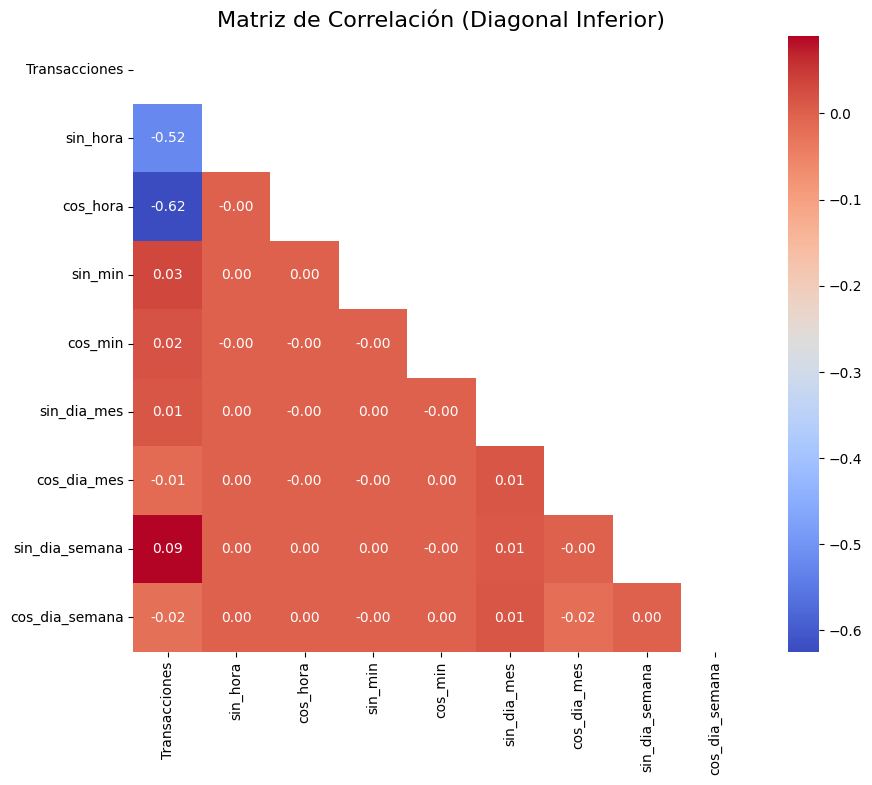

In [102]:
# Para la insercion de la input data en el modelo, solo consideraremos los datos totales de transaccion
# Calcular la matriz de correlación
correlation_matrix = df_desglosado.corr()

# Configuración del tamaño de la figura
plt.figure(figsize=(10, 8))

# Crear una máscara para el triángulo superior
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Crear un mapa de calor de la matriz de correlación
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)

# Configurar el título del gráfico
plt.title('Matriz de Correlación (Diagonal Inferior)', fontsize=16)

# Mostrar el gráfico
plt.show()

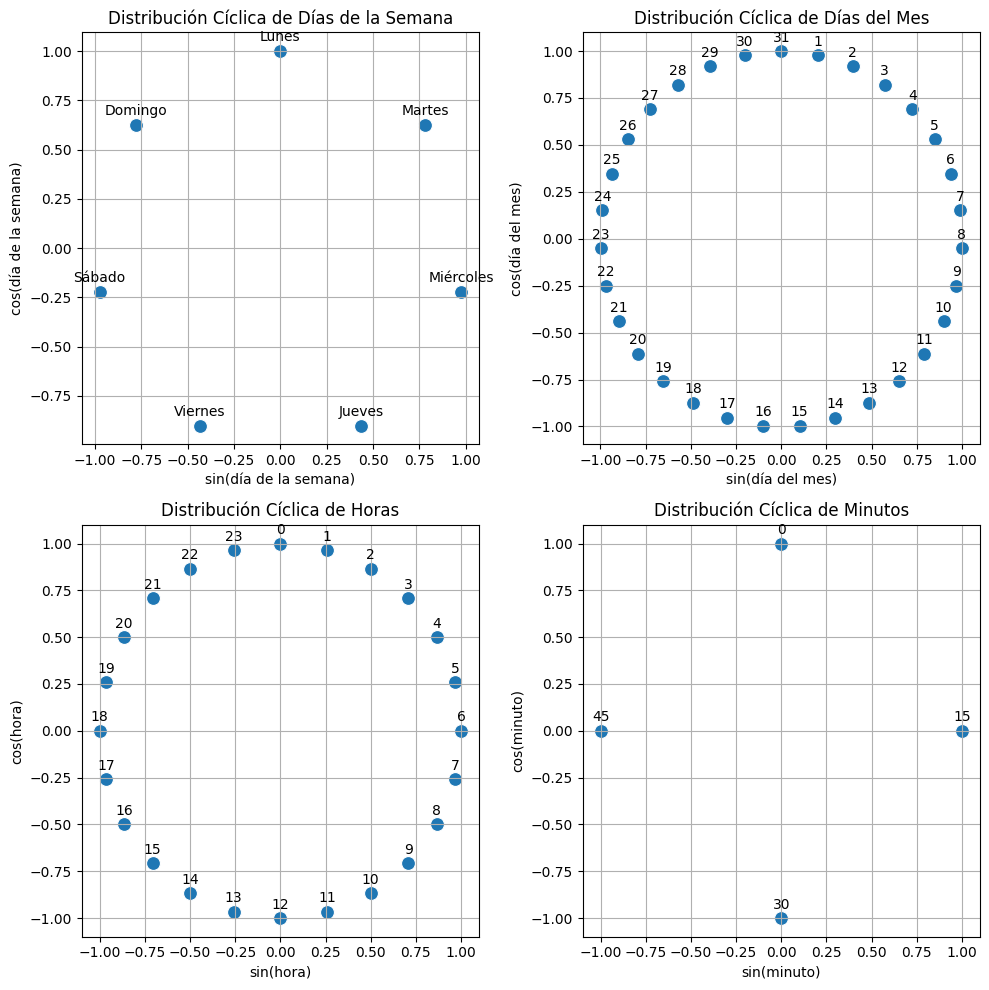

In [101]:
# Días de la semana
dias_semana = np.arange(7)
sin_dia_semana = np.sin(2 * np.pi * dias_semana / 7)
cos_dia_semana = np.cos(2 * np.pi * dias_semana / 7)
nombres_dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

# Días del mes
dias_mes = np.arange(1, 32)
sin_dia_mes = np.sin(2 * np.pi * dias_mes / 31)
cos_dia_mes = np.cos(2 * np.pi * dias_mes / 31)

# Horas
horas = np.arange(24)
sin_horas = np.sin(2 * np.pi * horas / 24)
cos_horas = np.cos(2 * np.pi * horas / 24)

# Minutos
minutos = np.arange(0,60,step=15)
sin_minutos = np.sin(2 * np.pi * minutos / 60)
cos_minutos = np.cos(2 * np.pi * minutos / 60)

# DataFrames
df_semana = pd.DataFrame({
    'Día de la Semana': nombres_dias,
    'sin_dia_semana': sin_dia_semana,
    'cos_dia_semana': cos_dia_semana
})

df_mes = pd.DataFrame({
    'Día del Mes': dias_mes,
    'sin_dia_mes': sin_dia_mes,
    'cos_dia_mes': cos_dia_mes
})

df_horas = pd.DataFrame({
    'Hora': horas,
    'sin_horas': sin_horas,
    'cos_horas': cos_horas
})

df_minutos = pd.DataFrame({
    'Minuto': minutos,
    'sin_minutos': sin_minutos,
    'cos_minutos': cos_minutos
})

plt.figure(figsize=(10, 10))

# Subplot 1: Días de la semana
plt.subplot(2, 2, 1)
sns.scatterplot(x='sin_dia_semana', y='cos_dia_semana', data=df_semana, s=100)
for i in range(len(df_semana)):
    plt.text(df_semana['sin_dia_semana'][i], 
             df_semana['cos_dia_semana'][i] + 0.05, 
             df_semana['Día de la Semana'][i], 
             horizontalalignment='center', 
             size='medium', 
             color='black')
plt.xlabel('sin(día de la semana)')
plt.ylabel('cos(día de la semana)')
plt.title('Distribución Cíclica de Días de la Semana')
plt.grid(True)

# Subplot 2: Días del mes
plt.subplot(2, 2, 2)
sns.scatterplot(x='sin_dia_mes', y='cos_dia_mes', data=df_mes, s=100)
for i in range(len(df_mes)):
    plt.text(df_mes['sin_dia_mes'][i], 
             df_mes['cos_dia_mes'][i] + 0.05, 
             str(df_mes['Día del Mes'][i]), 
             horizontalalignment='center', 
             size='medium', 
             color='black')
plt.xlabel('sin(día del mes)')
plt.ylabel('cos(día del mes)')
plt.title('Distribución Cíclica de Días del Mes')
plt.grid(True)

# Subplot 3: Horas
plt.subplot(2, 2, 3)
sns.scatterplot(x='sin_horas', y='cos_horas', data=df_horas, s=100)
for i in range(len(df_horas)):
    plt.text(df_horas['sin_horas'][i], 
             df_horas['cos_horas'][i] + 0.05, 
             str(df_horas['Hora'][i]), 
             horizontalalignment='center', 
             size='medium', 
             color='black')
plt.xlabel('sin(hora)')
plt.ylabel('cos(hora)')
plt.title('Distribución Cíclica de Horas')
plt.grid(True)

# Subplot 4: Minutos
plt.subplot(2, 2, 4)
sns.scatterplot(x='sin_minutos', y='cos_minutos', data=df_minutos, s=100)
for i in range(len(df_minutos)):
    plt.text(df_minutos['sin_minutos'][i], 
             df_minutos['cos_minutos'][i] + 0.05, 
             str(df_minutos['Minuto'][i]), 
             horizontalalignment='center', 
             size='medium', 
             color='black')
plt.xlabel('sin(minuto)')
plt.ylabel('cos(minuto)')
plt.title('Distribución Cíclica de Minutos')
plt.grid(True)

plt.tight_layout()
plt.show()


La matriz de correlación revela que el dia de la semana tiene un impacto considerable en el volumen total de transacciones, debido a la forma ciclicla en la que se presentan las horas, la coorrelacion positiva de sin_dia_semana lleva al primer y cuarto cuadrante, el cual representa los dias martes, miércoles o jueves los cuales son los que reciben la mayor cantidad de transacciones, lo cual se condice con los graficos anteriormente estudiados. Asi mismo sin_dia_del mes y cos_dia del mes tiene una coorrelacion tanto positiva como negativa respectivamente de 0.1 y -0.1 lo que indica una leve tendencia a una mayor cantidad de transacciones en el cuarto cuadrante cada mes.

## Actividad 2

In [103]:
# Division de los datos disponibles
X = df_desglosado.drop(columns=['Transacciones']).values
y = df_desglosado['Transacciones'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=33)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.4, random_state=33)

In [105]:
scaler = StandardScaler().fit(y_train.reshape(-1,1))

y_train_scaled = scaler.transform(y_train.reshape(-1,1))

# Crear modelo 1
model = DecisionTreeRegressor(random_state=33)

# Tunear Hyperparametros


model.fit(X_train, y_train_scaled)

DecisionTreeRegressor(random_state=33)

In [111]:
# Tuneo de 

y_val_pred = scaler.inverse_transform(model.predict(X_val).reshape(-1,1)).flatten()
val_rmse = root_mean_squared_error(y_val,y_val_pred)
val_mae = mean_absolute_error(y_val,y_val_pred)
r2 = r2_score(y_val,y_val_pred)
print("Root Mean Squared Error:", val_rmse)
print("Mean Absolute Error:", val_mae)
print("R2:", r2)

Root Mean Squared Error: 9.067815468776583
Mean Absolute Error: 5.0144717800290435
R2: 0.8373587502362124


In [107]:
y_test_pred = scaler.inverse_transform(model.predict(X_test).reshape(-1,1)).flatten()
val_rmse = root_mean_squared_error(y_test,y_test_pred)
val_mae = mean_absolute_error(y_test,y_test_pred)
print(val_rmse, val_mae)

14.276147504255771 5.496023138105664


In [ ]:
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))

# Keep X_train unchanged (do not scale sine and cosine columns)
X_train_reshaped = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))